In [2]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 90 kB 8.6 MB/s 
     |████████████████████████████████| 352 kB 48.2 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 
     |████████████████████████████████| 213 kB 49.3 MB/s 
     |████████████████████████████████| 99 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.6 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 35.1 MB/s 


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
# Download the IMDB dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 5s 0us/step


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
# Preprocessing layer
# Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.
# The preprocessing model must be the one referenced by the documentation of the BERT model
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [7]:
# preprocessing trial
# The input is truncated to 128 tokens
# input_type_ids only have one value (0) because this is a single sentence input.
# For a multiple sentence input, it would have one number for each input.
# input_mask allows the model to differentiate between the content and the padding.
# The mask has the same shape as the input ids, and contains 1 anywhere the input ids is not padding.
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# model
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [9]:
# model trial
# pooled_output represents each input sequence as a whole. shape = [batch_size, H].
# You can think of this as an embedding for the entire movie review.
# sequence_output represents each input token in the context. shape = [batch_size, seq_length, H].
# You can think of this as a contextual embedding for every token in the movie review.
# encoder_outputs are the intermediate activations of the L Transformer blocks.
# outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024]
# with the outputs of the i-th Transformer block, for 0 <= i < L.
# The last value of the list is equal to sequence_output.
bert_results = bert_model(text_preprocessed)
print(f'Keys: {bert_results.keys()}')
print(f'Pooled Outputs Shape: {bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:  {bert_results["pooled_output"].numpy()[0, :5]}')
print(f'Sequence Outputs Shape: {bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:  {bert_results["sequence_output"].numpy()[0, 0, :5]}')

Keys: dict_keys(['sequence_output', 'encoder_outputs', 'default', 'pooled_output'])
Pooled Outputs Shape: (1, 512)
Pooled Outputs Values:  [ 0.7626282   0.9928099  -0.18611862  0.3667383   0.15233758]
Sequence Outputs Shape: (1, 128, 512)
Sequence Outputs Values:  [-0.28946292  0.34321183  0.33231512 -1.0911367  -0.8907285 ]


In [47]:
# Define model architecture with fine tuning layers
PREPROCESS_PATH = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
BERT_PATH = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

def BertClassifier():
    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer(PREPROCESS_PATH)
    bert_encoder = hub.KerasLayer(BERT_PATH, trainable=True)
    dropout = tf.keras.layers.Dropout(0.1)
    classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    x = preprocessor(input_layer)
    x = bert_encoder(x)['pooled_output']
    x = dropout(x)
    x = classifier(x)
    return tf.keras.models.Model(input_layer, x)

In [48]:
model = BertClassifier()

In [49]:
# full model trial
model(tf.constant(text_test)).numpy()

array([[0.7217665]], dtype=float32)

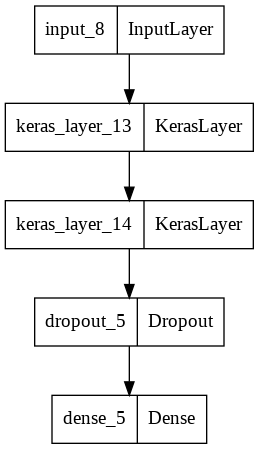

In [50]:
tf.keras.utils.plot_model(model)

In [51]:
loss = tf.keras.losses.BinaryCrossentropy()

In [52]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(num_train_steps * 0.1)

init_lr = 3e-5
custom_adam = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [53]:
model.compile(loss=loss, optimizer=custom_adam, metrics=tf.keras.metrics.BinaryAccuracy())

In [54]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
625/625 [==============================] - 296s 462ms/step - loss: 0.4850 - binary_accuracy: 0.7541 - val_loss: 0.3820 - val_binary_accuracy: 0.8300
Epoch 2/5
625/625 [==============================] - 287s 459ms/step - loss: 0.3251 - binary_accuracy: 0.8608 - val_loss: 0.3633 - val_binary_accuracy: 0.8426
Epoch 3/5
625/625 [==============================] - 286s 458ms/step - loss: 0.2489 - binary_accuracy: 0.9002 - val_loss: 0.3899 - val_binary_accuracy: 0.8520
Epoch 4/5
625/625 [==============================] - 286s 457ms/step - loss: 0.1915 - binary_accuracy: 0.9287 - val_loss: 0.4298 - val_binary_accuracy: 0.8536
Epoch 5/5
625/625 [==============================] - 286s 458ms/step - loss: 0.1491 - binary_accuracy: 0.9466 - val_loss: 0.4767 - val_binary_accuracy: 0.8552


In [55]:
model.evaluate(test_ds, verbose=2)

782/782 - 145s - loss: 0.4661 - binary_accuracy: 0.8576 - 145s/epoch - 186ms/step


[0.466109037399292, 0.8576400279998779]